In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json

In [2]:
results_dir = './results/models'

In [3]:
def template_to_regex(model_name, dataset, lp=False, model_postfix=''):
    # Escape any special regex characters in model_name
    model_prefix = re.escape(model_name)
    model_postfix = '' if model_postfix == '' else f"_{model_postfix}"
    pattern = model_prefix
    pattern += r"_b(\d+)_d(\d+)"
    
    # Build the pattern in parts
    pattern += f"_{dataset}{model_postfix}"  # Fixed model name prefix
    if lp:
        pattern += r"_lp"          # Optional _lp
    pattern += r"_lr(\d+(?:\.\d+)?e?-?\d*)"  # Learning rate in decimal or scientific notation
    pattern += r"_wd(\d+(?:\.\d+)?e?-?\d*)"  # Weight decay in decimal or scientific notation
    pattern += r"(.*)"            # Any remaining postfix
    
    return pattern


In [4]:
def get_target_logs(target_dirs, dataset):
    results = []
    for target_dir in target_dirs:
        log_path = os.path.join(results_dir, target_dir, "test_results.json")
        try:    
            with open(log_path, 'r') as f:
                log = json.load(f)
            # log['model'] = target_dir
        # parse the model_dir
            log["base_model"] = target_dir.split(f"_{dataset}")[0]
            log['lr'] = float(re.search(r"lr(\d+(?:\.\d+)?e?-?\d*)", target_dir).group(1))
            log['weight_decay'] = float(re.search(r"wd(\d+(?:\.\d+)?e?-?\d*)", target_dir).group(1))
            log['checkpoint'] = int(re.search(r"ckpt(\d+)", target_dir).group(1))
            log['moe'] = int(re.search(r"moe(-?\d+)", target_dir).group(1))
            log['moe'] = 14 if log['moe'] == -1 else log['moe']
            log['eval_accuracy'] *= 100
            log['pretrain_depth'] = int(re.search(r"d(\d+)", target_dir).group(1))
            log['channel_dims'] = int(re.search(r"b(\d+)", target_dir).group(1))
            results.append(log)
        except:
            continue
        # convert to df
        df = pd.DataFrame(results).drop(columns=['eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second'])
    return df

In [5]:
def get_model_name(result_dirs, model_pattern):
    filtered_model_names = []
    for result_dir in os.listdir(result_dirs):
        if re.match(model_pattern, result_dir):
            filtered_model_names.append(result_dir)
    return filtered_model_names

In [6]:
model_name = "LESSVIT"
dataset = 'eurosat'
lp = False
pattern = template_to_regex(model_name, dataset, lp)
   
filtered_model_names = get_model_name(results_dir, pattern)
df_all = get_target_logs(filtered_model_names, dataset)
# filtered_model_names

In [7]:
df_all = df_all.sort_values(by=['eval_accuracy'], ascending=False).loc[(df_all.lr==0.0003)]
df_all


,epoch,eval_accuracy,eval_loss,base_model,lr,weight_decay,checkpoint,moe,pretrain_depth,channel_dims
18,18.897638,97.333333,0.121619,LESSVIT_b1_d2,0.0003,0.01,50000,0,2,1
8,20.000000,97.203704,0.115608,LESSVIT_b1_d4,0.0003,0.01,30000,5,4,1
2,20.000000,97.129630,0.126144,LESSVIT_b1_d4,0.0003,0.01,30000,3,4,1
7,20.000000,97.111111,0.129636,LESSVIT_b1_d4,0.0003,0.01,50000,5,4,1
3,20.000000,97.018519,0.122171,LESSVIT_b2_d6,0.0003,0.01,30000,1,6,2
19,20.000000,97.018519,0.139598,LESSVIT_b1_d4,0.0003,0.01,40000,1,4,1
5,20.000000,97.000000,0.118658,LESSVIT_b1_d4,0.0003,0.01,40000,5,4,1
1,20.000000,96.981481,0.130885,LESSVIT_b1_d4,0.0003,0.01,30000,10,4,1
9,20.000000,96.962963,0.133065,LESSVIT_b2_d4,0.0003,0.01,30000,3,4,2
17,20.000000,96.944444,0.129716,LESSVIT_b1_d4,0.0003,0.01,50000,3,4,1


In [106]:
df_ckpt = df_all.loc[df_all["checkpoint"]==30000].sort_values(by=['eval_accuracy'], ascending=False)
df_ckpt

,epoch,eval_accuracy,eval_loss,base_model,lr,weight_decay,checkpoint,moe,pretrain_depth,channel_dims
7,20.0,97.203704,0.115608,LESSVIT_b1_d4,0.0003,0.01,30000,5,4,1
2,20.0,97.129630,0.126144,LESSVIT_b1_d4,0.0003,0.01,30000,3,4,1
3,20.0,97.018519,0.122171,LESSVIT_b2_d6,0.0003,0.01,30000,1,6,2
1,20.0,96.981481,0.130885,LESSVIT_b1_d4,0.0003,0.01,30000,10,4,1
8,20.0,96.962963,0.133065,LESSVIT_b2_d4,0.0003,0.01,30000,3,4,2
13,20.0,96.925926,0.129648,LESSVIT_b2_d6,0.0003,0.01,30000,3,6,2
14,20.0,96.925926,0.120280,LESSVIT_b2_d6,0.0003,0.01,30000,5,6,2
9,20.0,96.851852,0.116128,LESSVIT_b2_d6,0.0003,0.01,30000,10,6,2
10,20.0,96.814815,0.151437,LESSVIT_b1_d4,0.0003,0.01,30000,1,4,1
5,20.0,96.648148,0.132252,LESSVIT_b2_d4,0.0003,0.01,30000,5,4,2


In [77]:
df_depth = df_ckpt.loc[df_ckpt["pretrain_depth"]==4].sort_values(by=['eval_accuracy'], ascending=False)
df_depth

,epoch,eval_accuracy,eval_loss,base_model,lr,weight_decay,checkpoint,moe,pretrain_depth,channel_dims
6,20.0,97.203704,0.115608,LESSVIT_b1_d4,0.0003,0.01,30000,5,4,1
2,20.0,97.129630,0.126144,LESSVIT_b1_d4,0.0003,0.01,30000,3,4,1
1,20.0,96.981481,0.130885,LESSVIT_b1_d4,0.0003,0.01,30000,10,4,1
7,20.0,96.962963,0.133065,LESSVIT_b2_d4,0.0003,0.01,30000,3,4,2
9,20.0,96.814815,0.151437,LESSVIT_b1_d4,0.0003,0.01,30000,1,4,1
4,20.0,96.648148,0.132252,LESSVIT_b2_d4,0.0003,0.01,30000,5,4,2
19,20.0,96.481481,0.119054,LESSVIT_b2_d4,0.0003,0.01,30000,1,4,2


In [78]:
df_channel = df_ckpt.loc[df_ckpt["channel_dims"]==2].sort_values(by=['eval_accuracy'], ascending=False)
df_channel


,epoch,eval_accuracy,eval_loss,base_model,lr,weight_decay,checkpoint,moe,pretrain_depth,channel_dims
3,20.0,97.018519,0.122171,LESSVIT_b2_d6,0.0003,0.01,30000,1,6,2
7,20.0,96.962963,0.133065,LESSVIT_b2_d4,0.0003,0.01,30000,3,4,2
12,20.0,96.925926,0.129648,LESSVIT_b2_d6,0.0003,0.01,30000,3,6,2
13,20.0,96.925926,0.120280,LESSVIT_b2_d6,0.0003,0.01,30000,5,6,2
8,20.0,96.851852,0.116128,LESSVIT_b2_d6,0.0003,0.01,30000,10,6,2
4,20.0,96.648148,0.132252,LESSVIT_b2_d4,0.0003,0.01,30000,5,4,2
19,20.0,96.481481,0.119054,LESSVIT_b2_d4,0.0003,0.01,30000,1,4,2


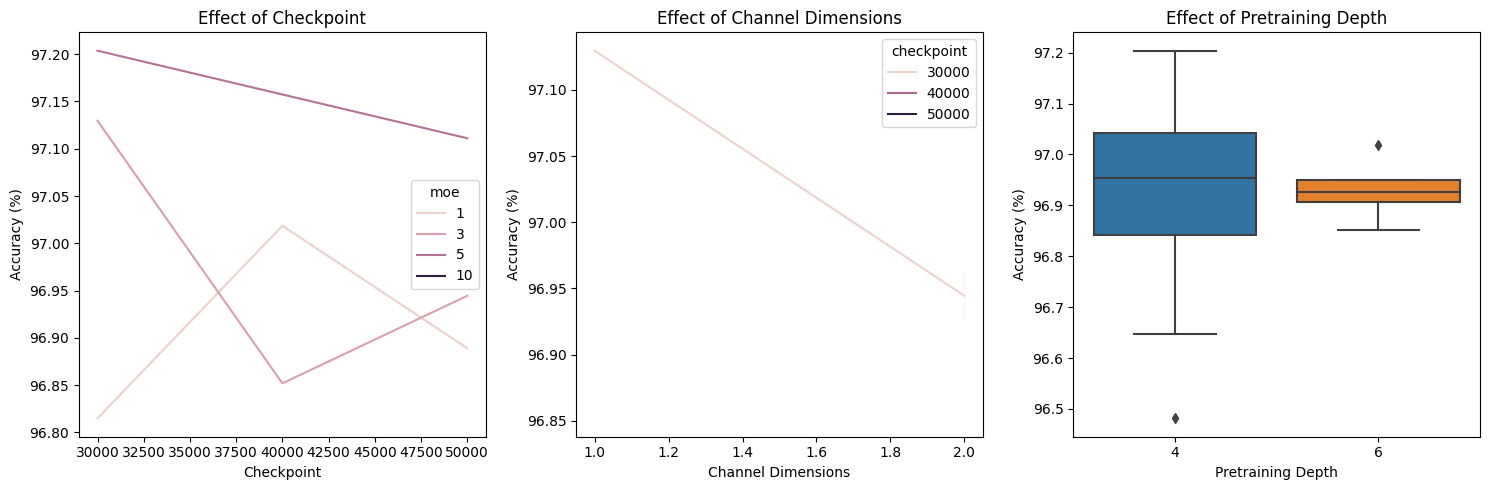

In [90]:
# Set up figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Checkpoint ablation
sns.lineplot(data=df_all.loc[df_all['base_model']=='LESSVIT_b1_d4'], x='checkpoint', y='eval_accuracy', hue='moe', ax=ax1)
ax1.set_title('Effect of Checkpoint')
ax1.set_xlabel('Checkpoint')
ax1.set_ylabel('Accuracy (%)')

# Plot 2: Channel dimensions ablation  
sns.lineplot(data=df_all.loc[df_all['moe']==3], x='channel_dims', y='eval_accuracy', hue='checkpoint', ax=ax2)
ax2.set_title('Effect of Channel Dimensions')
ax2.set_xlabel('Channel Dimensions')
ax2.set_ylabel('Accuracy (%)')

# Plot 3: Pretraining depth ablation
sns.boxplot(data=df_all, x='pretrain_depth', y='eval_accuracy', ax=ax3)
ax3.set_title('Effect of Pretraining Depth')
ax3.set_xlabel('Pretraining Depth')
ax3.set_ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()



In [100]:
model_name = "LESSVIT"
dataset = 'eurosat'
lp = True
pattern = template_to_regex(model_name, dataset, lp)
   
filtered_model_names = get_model_name(results_dir, pattern)
df_lp = get_target_logs(filtered_model_names, dataset)
# filtered_model_names

In [101]:
df_lp = df_lp.sort_values(by=['eval_accuracy'], ascending=False)
df_lp


,epoch,eval_accuracy,eval_loss,base_model,lr,weight_decay,checkpoint,moe,pretrain_depth,channel_dims
1,99.408284,91.685185,0.284066,LESSVIT_b1_d4,0.01,0.01,50000,1,4,1
0,99.408284,91.666667,0.283873,LESSVIT_b1_d4,0.01,0.01,50000,5,4,1
2,99.408284,91.666667,0.283384,LESSVIT_b1_d4,0.01,0.01,50000,3,4,1
